In [48]:
import pandas as pd
import datetime
from fbprophet import Prophet
# Upgrade pyplot 
#pip install --upgrade plotly
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet.plot import plot_cross_validation_metric

# After importing the modules, we are defining our functions:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Number of days for the prediction

In the next line we are going to choose the number of days we want to predict. For this project we have chosen 7 days, but it can be changed for investigating:

In [2]:
days = 28

## Facebook prophet

We read the data:

In [3]:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')


We must give the format needed to the dataframe. We need to have a column named `"ds"` with the dates, and a column named `"y"` with the value

In [4]:
# Select the columns we need
new_df = df.reset_index()[['datetime','Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']]
# Rename them
new_df.columns= ['ds','y']
# Give the date column the right format
new_df.ds = pd.to_datetime(new_df.ds)
new_df.ds = new_df.ds.dt.strftime("%Y-%m-%d %H:%M:%S")

In [5]:
# Let's select for train and test based on the number of days we selected before:
last_value = new_df.shape[0]-days*24
train = new_df.iloc[:last_value,]
test = new_df.iloc[last_value:,]

We can now fit the model:

In [6]:
m = Prophet()
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Let's check our model. We are going to see what  th metrics are for a cross valdiation on the fitted data. 

In [7]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = str(days)+' days')

INFO:fbprophet:Making 9 forecasts with cutoffs between 2016-07-19 21:00:00 and 2020-06-28 21:00:00


In [29]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)

In [46]:
df_p

horizon         mse       rmse        mae      mape     mdape  \
0    2 days 20:00:00  126.768392  11.259147   8.628030  0.104917  0.071913   
1    2 days 21:00:00  126.997104  11.269299   8.640251  0.103513  0.071459   
2    2 days 22:00:00  126.230281  11.235225   8.621771  0.101953  0.070130   
3    2 days 23:00:00  133.202145  11.541323   8.819098  0.101895  0.071459   
4    3 days 00:00:00  136.136294  11.667746   8.920681  0.103190  0.072040   
..               ...         ...        ...        ...       ...       ...   
600 27 days 20:00:00  204.721953  14.308108  11.495927  0.153230  0.115476   
601 27 days 21:00:00  204.967093  14.316672  11.478991  0.151115  0.113898   
602 27 days 22:00:00  204.366671  14.295687  11.440512  0.148921  0.111005   
603 27 days 23:00:00  209.261007  14.465857  11.537410  0.147816  0.109797   
604 28 days 00:00:00  214.030555  14.629783  11.626310  0.148821  0.109456   

     coverage  
0    0.857432  
1    0.855408  
2    0.857432  
3    0.849154  
4    0.842531  
..        ...  
600  0.770787  
601  0.769316  
602  0.769500  
603  0.766004  
604  0.759566  

[605 rows x 7 columns]

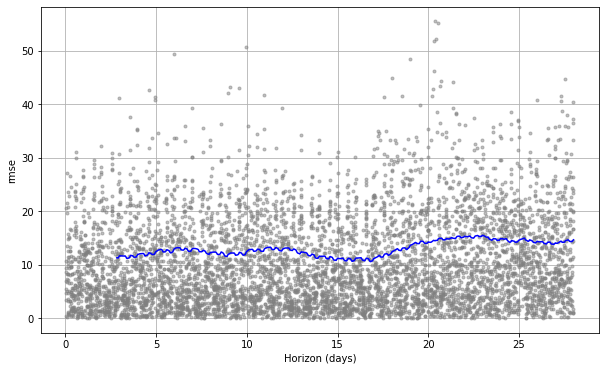

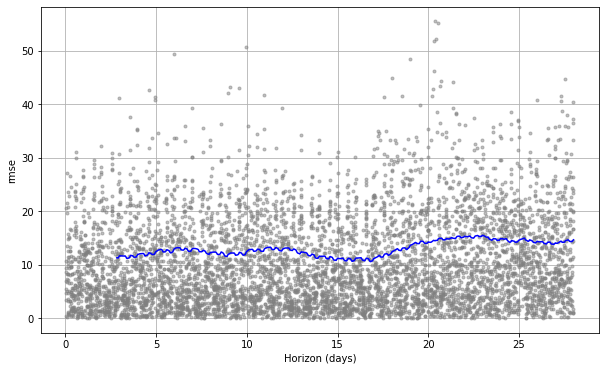

In [51]:
plot_cross_validation_metric(df_cv, metric = 'rmse')

Once we have the metrics for our model, let's predict and check it:

In [9]:
forecast = m.predict(test[['ds']])
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
667 2020-08-23 17:00:00  101.826267   85.678082  118.842633
668 2020-08-23 18:00:00  111.789873   95.037181  128.638402
669 2020-08-23 19:00:00  105.415065   89.264393  122.859427
670 2020-08-23 20:00:00   81.091847   63.896736   98.851184
671 2020-08-23 21:00:00   50.491147   34.029261   67.338043

Once we have the predictions, we are having a look at the forecasting:

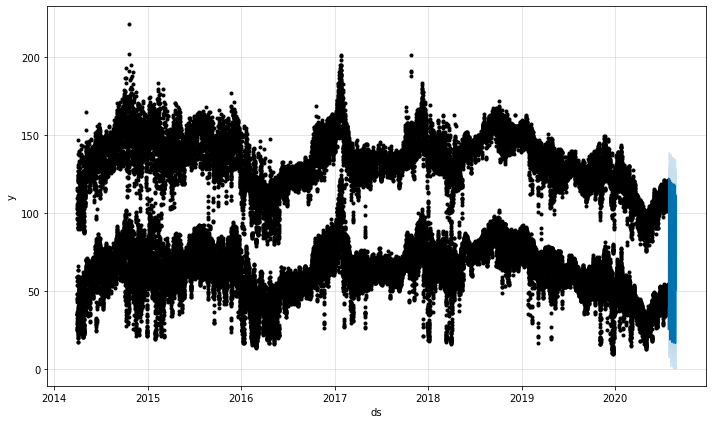

In [10]:
fig1 = m.plot(forecast)

Within the next line, we are seeing the main components from the model:

In [11]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_components_plotly(m, forecast)

There is an interactive option for this library. With the function, using plotly, you can see an interactive plot of the data, where you can select the dates you want to check and it zooms them. The problem is that it gets slow when you use this function, so it will only be used if wanted. For safety, we are keeping it as a markdown cell with the code.

```python
from fbprophet.plot import plot_plotly, plot_components_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast[yhat])  # This returns a plotly Figure
py.iplot(fig)
```


Finally, let's check the results

In [12]:
forecast

ds      trend  yhat_lower  yhat_upper  trend_lower  \
0   2020-07-26 22:00:00  62.502002   15.266815   49.738864    62.502002   
1   2020-07-26 23:00:00  62.499061    9.497856   42.055798    62.499061   
2   2020-07-27 00:00:00  62.496120   10.514236   44.334233    62.496120   
3   2020-07-27 01:00:00  62.493179   13.113027   47.276002    62.493179   
4   2020-07-27 02:00:00  62.490238   12.147638   45.026427    62.490238   
..                  ...        ...         ...         ...          ...   
667 2020-08-23 17:00:00  60.540289   85.678082  118.842633    60.327479   
668 2020-08-23 18:00:00  60.537348   95.037181  128.638402    60.323429   
669 2020-08-23 19:00:00  60.534407   89.264393  122.859427    60.319379   
670 2020-08-23 20:00:00  60.531466   63.896736   98.851184    60.315329   
671 2020-08-23 21:00:00  60.528525   34.029261   67.338043    60.311278   

     trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0      62.502002      -29.802298            -29.802298            -29.802298   
1      62.499061      -36.980830            -36.980830            -36.980830   
2      62.496120      -34.728440            -34.728440            -34.728440   
3      62.493179      -32.525526            -32.525526            -32.525526   
4      62.490238      -34.349121            -34.349121            -34.349121   
..           ...             ...                   ...                   ...   
667    60.715600       41.285978             41.285978             41.285978   
668    60.713250       51.252525             51.252525             51.252525   
669    60.710899       44.880658             44.880658             44.880658   
670    60.708549       20.560381             20.560381             20.560381   
671    60.706302      -10.037378            -10.037378            -10.037378   

         daily  ...    weekly  weekly_lower  weekly_upper    yearly  \
0   -28.731766  ... -2.784364     -2.784364     -2.784364  1.713832   
1   -36.256934  ... -2.427179     -2.427179     -2.427179  1.703283   
2   -34.353588  ... -2.067581     -2.067581     -2.067581  1.692729   
3   -32.499676  ... -1.708019     -1.708019     -1.708019  1.682169   
4   -34.669824  ... -1.350902     -1.350902     -1.350902  1.671604   
..         ...  ...       ...           ...           ...       ...   
667  46.252909  ... -4.448393     -4.448393     -4.448393 -0.518538   
668  55.909885  ... -4.139832     -4.139832     -4.139832 -0.517528   
669  49.213994  ... -3.816808     -3.816808     -3.816808 -0.516528   
670  24.557546  ... -3.481626     -3.481626     -3.481626 -0.515539   
671  -6.386150  ... -3.136667     -3.136667     -3.136667 -0.514561   

     yearly_lower  yearly_upper  multiplicative_terms  \
0        1.713832      1.713832                   0.0   
1        1.703283      1.703283                   0.0   
2        1.692729      1.692729                   0.0   
3        1.682169      1.682169                   0.0   
4        1.671604      1.671604                   0.0   
..            ...           ...                   ...   
667     -0.518538     -0.518538                   0.0   
668     -0.517528     -0.517528                   0.0   
669     -0.516528     -0.516528                   0.0   
670     -0.515539     -0.515539                   0.0   
671     -0.514561     -0.514561                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                           0.0                         0.0   32.699705  
1                           0.0                         0.0   25.518231  
2                           0.0                         0.0   27.767680  
3                           0.0                         0.0   29.967653  
4                           0.0                         0.0   28.141116  
..                          ...                         ...         ...  
667                         0.0                         0.0  101.826267  
668                         0

Checking the forecasting for the last days:

Para los resultados de las últimas 4 semanas se obtiene un RMSE de  16.612492104400676 , un R2 de  0.7626520311459004  y un MAPE de 23.358023037339162


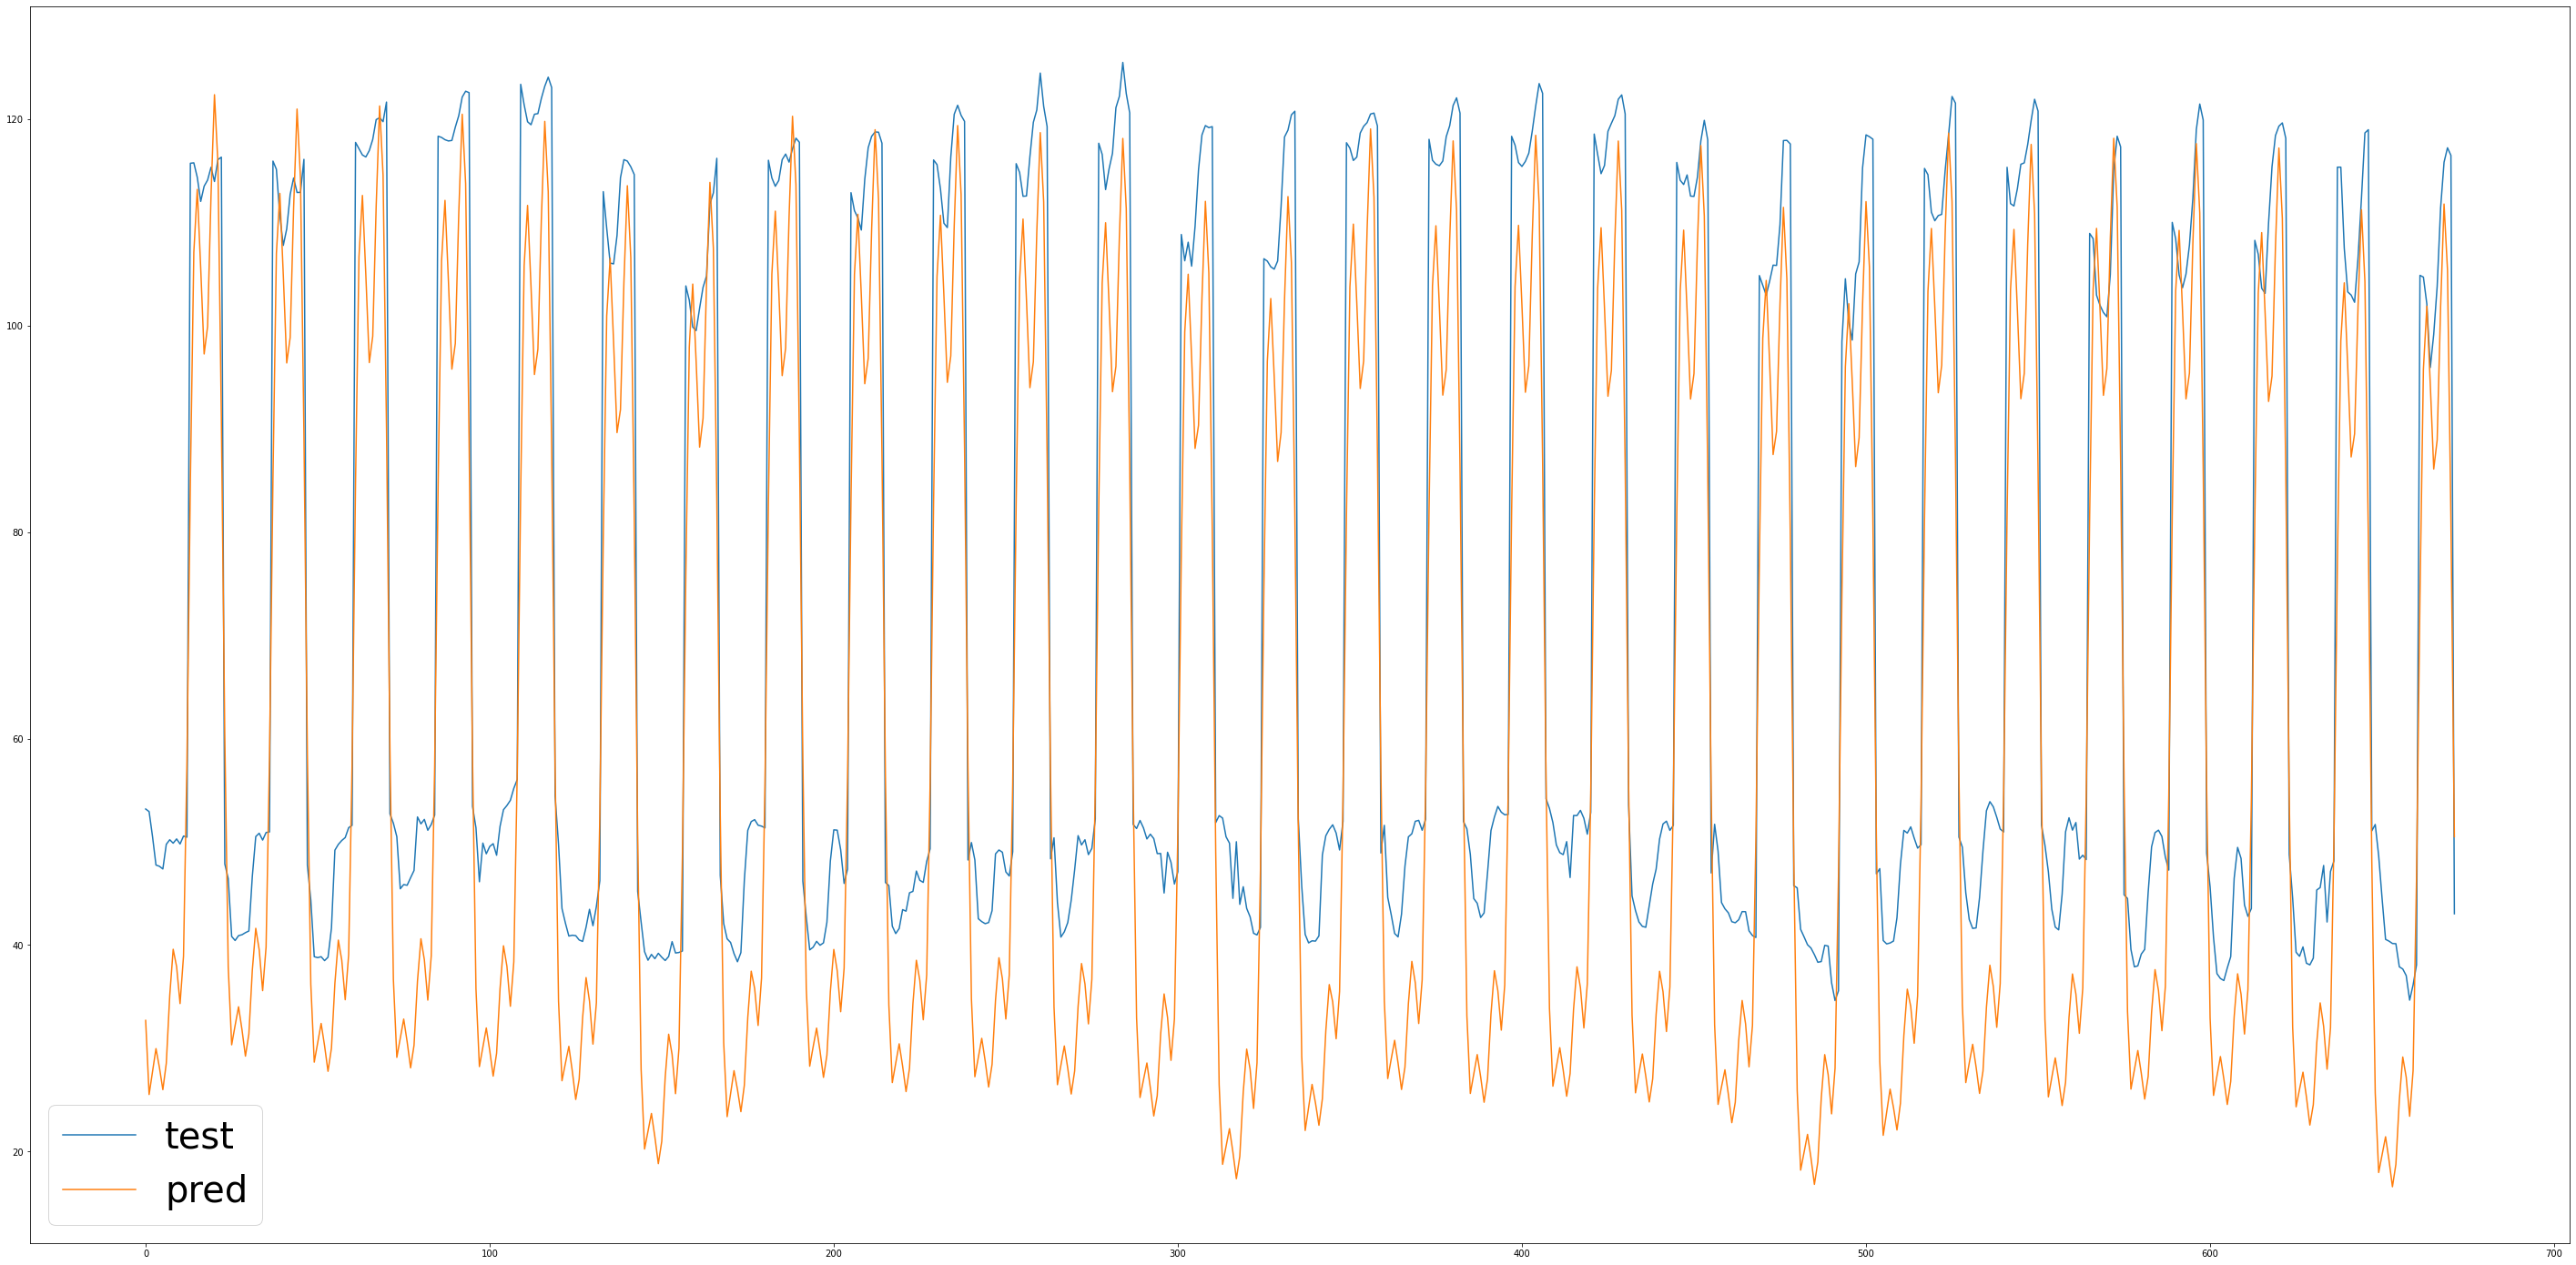

In [13]:
# Let's plot the results and check the metrics.
y_test_days = test['y'].copy()
y_pred_days = forecast['yhat'].copy()
print('Para los resultados de las últimas 4 semanas se obtiene un RMSE de ',np.sqrt(mean_squared_error(y_test_days, y_pred_days)),', un R2 de ',r2_score(y_test_days, y_pred_days),' y un MAPE de',mean_absolute_percentage_error(y_test_days, y_pred_days))
plt.rcParams['figure.figsize'] = [50, 25]
plt.plot(test['y'].reset_index().drop('index',axis=1), label='test')
plt.plot(forecast['yhat'], label='pred')
plt.legend(prop={'size': 40})
plt.show()

Finally, we export the results for the visualization

In [14]:
pd.DataFrame({'y_test':test['y'].values, 'y_pred':forecast['yhat'].values},index = test.index).to_csv('./../Visualization/Faceboo_prophet.csv')

## SARIMAX

First, we read the data:

In [15]:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

We can recycle the code from the FP model so we give our data the format needed:

In [16]:
# Select the columns we need
new_df = df.reset_index()[['datetime','Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']]
# Rename them
new_df.columns= ['ds','y']
# Give the date column the right format
new_df.ds = pd.to_datetime(new_df.ds)
new_df.ds = new_df.ds.dt.strftime("%Y-%m-%d %H:%M:%S")
# Finally we set again ds as index:
new_df = new_df.set_index('ds')

In [17]:
# Let's select for train and test based on the number of days we selected before:
last_value = new_df.shape[0]-days*24
train = new_df.iloc[:last_value,]
test = new_df.iloc[last_value:,]

Before we fit the model, as we said in the document from the project, we are using **auto_arima** so we can find the best model for our data. As it takes quite a lot of time to find the best model, we are just plotting the code used and the results obtained. It is important to say that, to avoid crashing, we reduced the size of the train data from April 2014 to January 2016.

>```python
train = train.loc['2016-01-01 00:00:00':]
start = new_df.index.get_loc('2016-01-01 00:00:00')
```

>```python
import pmdarima as pm
model = pm.auto_arima(
    train,
    stationary = False,
    m=12,
    n_jobs = -1,
    exogenous = df.iloc[start:last_value,list(df.columns).index('holidays')].values.reshape(df.shape[0]-start-last_value,1),
    suppress_warnings=True
)
```

>```python
model.summary()
```

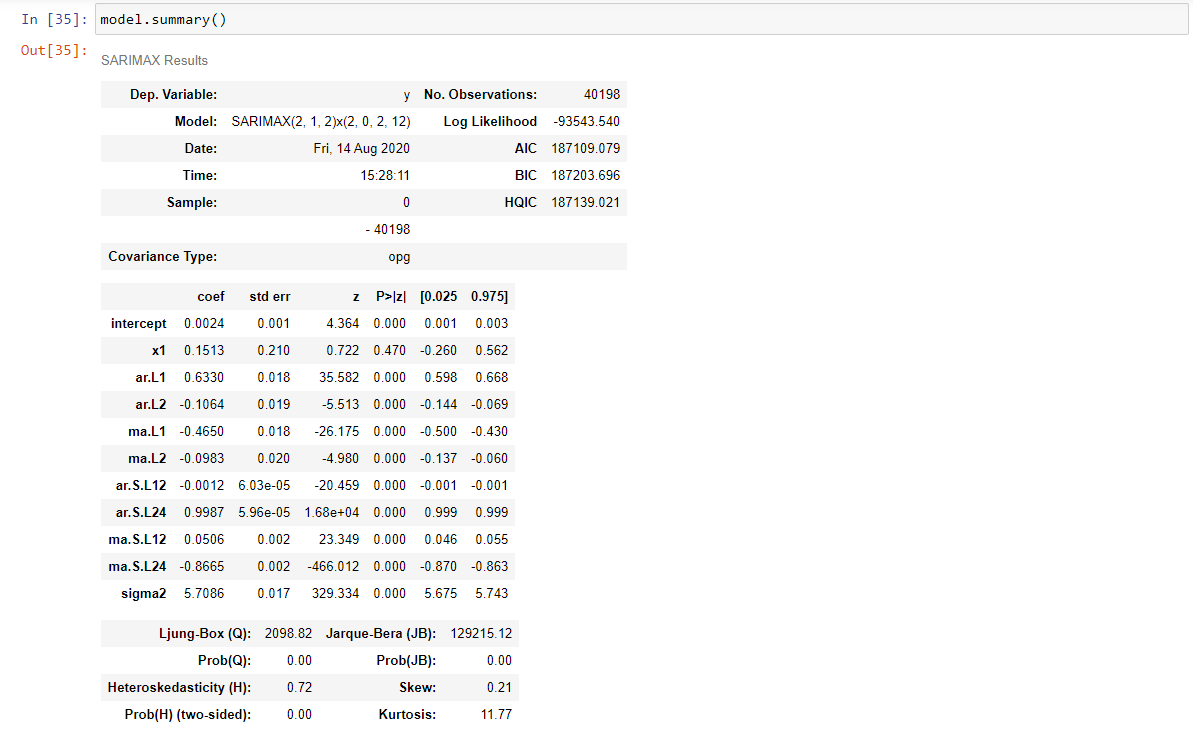

So, we fit the model with those hyperparameters:

In [22]:
model2 = SARIMAX(train, 
                 order = (2, 1, 2), 
                 seasonal_order = (2, 0, 2, 12),
                 exog = df.iloc[:last_value,list(df.columns).index('holidays')].values.reshape(df.shape[0]-24*days,1)
                ).fit()

/home/joeldela/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/home/joeldela/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/home/joeldela/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [23]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                55414
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 12)   Log Likelihood             -133112.962
Date:                            Mon, 31 Aug 2020   AIC                         266243.923
Time:                                    17:19:02   BIC                         266324.226
Sample:                                04-01-2014   HQIC                        266268.958
                                     - 07-26-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9005      0.010     87.723      0.000       0.880       0.921
ar.L2          0.0285      0.009      3.034      0.002       0.010       0.047
ma.L1         -0.7943      0.012    -66.597      0.000      -0.818      -0.771
ma.L2         -0.2039      0.012    -17.167      0.000      -0.227      -0.181
ar.S.L12      -0.0009   4.23e-05    -20.120      0.000      -0.001      -0.001
ar.S.L24       0.9991   4.38e-05   2.28e+04      0.000       0.999       0.999
ma.S.L12       0.0226      0.002     11.621      0.000       0.019       0.026
ma.S.L24      -0.8526      0.002   -527.725      0.000      -0.856      -0.849
sigma2         7.1512      0.021    341.999      0.000       7.110       7.192
===================================================================================
Ljung-Box (Q):                     1945.16   Jarque-Bera (JB):            105806.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.48   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We can plot the train and the fitted values so we know how our model performs in the train data:

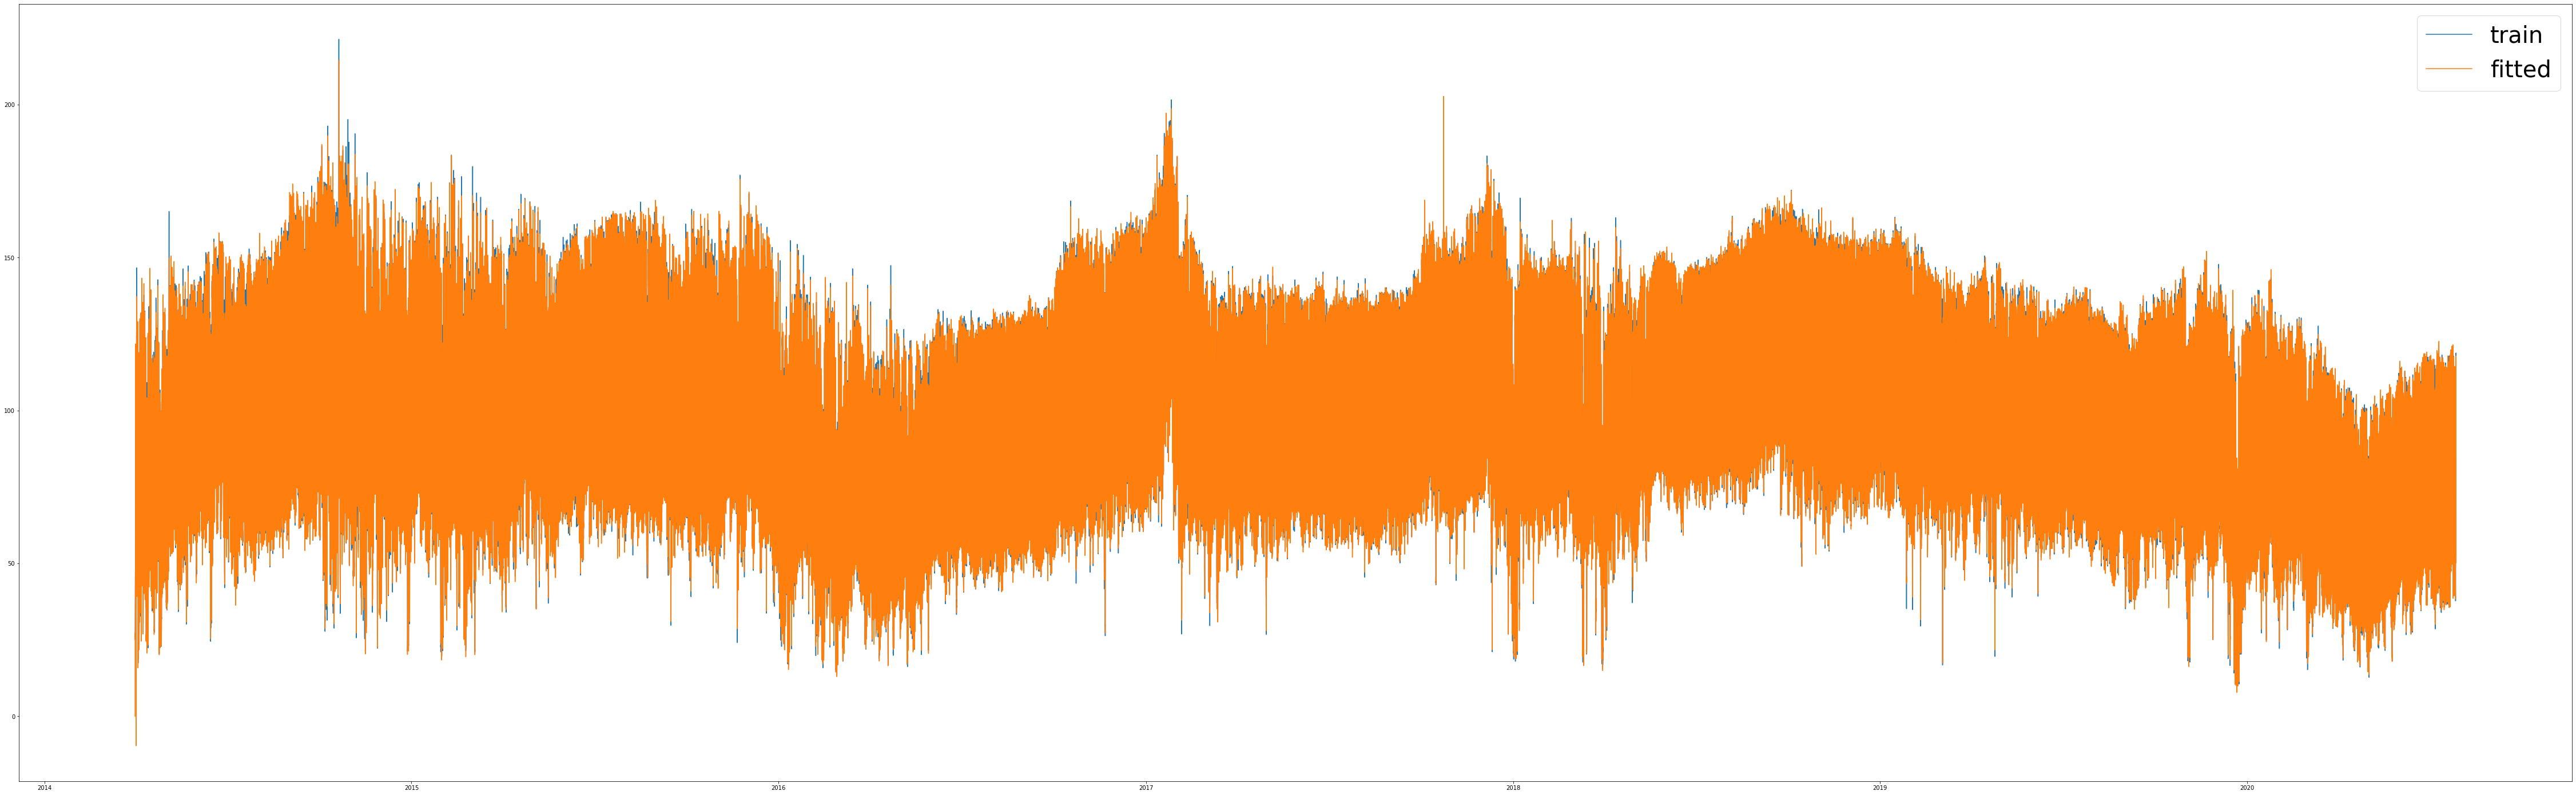

In [61]:
#Let's parse dates:
train.index = pd.to_datetime(train.index)
fitted_values = pd.Series(model2.fittedvalues)
fitted_values.index = pd.to_datetime(fitted_values.index)
# Let's plot both series:
plt.plot(train['y'], label='train')
plt.plot(fitted_values, label='fitted')
plt.legend(prop={'size': 40})

Let's predict the values for the number of hours and days selected before:

In [25]:
forecast_mean2 = model2.forecast(24*days, return_conf_int = True)
forecast_mean2

2020-07-26 22:00:00     53.163351
2020-07-26 23:00:00     48.557639
2020-07-27 00:00:00     46.236559
2020-07-27 01:00:00     46.580204
2020-07-27 02:00:00     46.273721
                          ...    
2020-08-23 17:00:00    116.948679
2020-08-23 18:00:00    118.270152
2020-08-23 19:00:00    119.476085
2020-08-23 20:00:00    120.132732
2020-08-23 21:00:00     53.533473
Freq: H, Length: 672, dtype: float64

Let's check the predictions:

Para los resultados de las últimas 4 semanas se obtiene un RMSE de  5.268911417059512 , un R2 de  0.9761242106446963  y un MAPE de 7.017296318457078


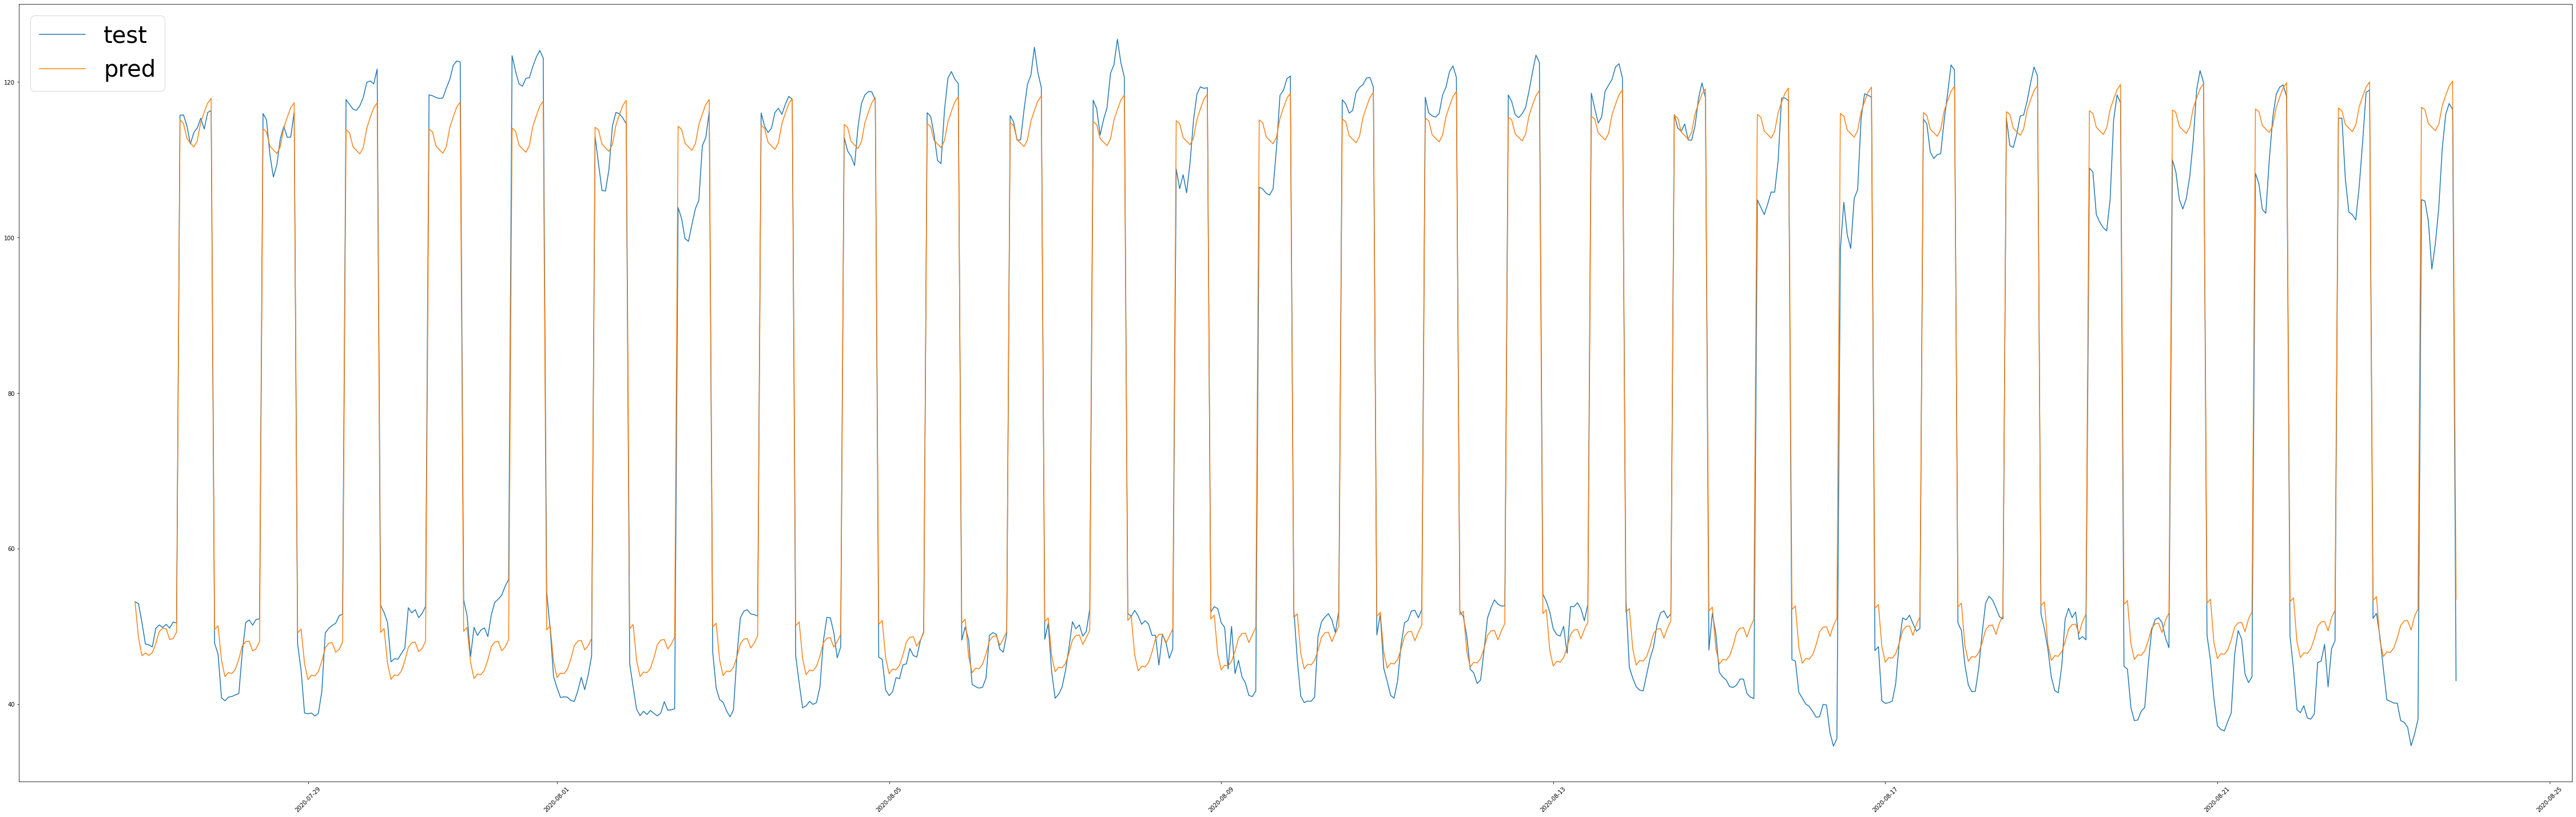

In [26]:
# Let's define the variables:
y_test = test['y']
y_pred = pd.Series(model2.forecast(24*days, return_conf_int = False), index=y_test.index)
y_test.index =  pd.to_datetime(y_test.index)
y_pred.index =  pd.to_datetime(y_pred.index)
# Now we print the metrics
print('Para los resultados de las últimas 4 semanas se obtiene un RMSE de ',np.sqrt(mean_squared_error(y_test, y_pred)),', un R2 de ',r2_score(y_test, y_pred),' y un MAPE de',mean_absolute_percentage_error(y_test, y_pred))
# Finally we plot the results:
plt.rcParams['figure.figsize'] = [80, 25]
plt.plot(y_test, label='test')
plt.plot(y_pred, label='pred')
plt.legend(prop={'size': 40})
plt.xticks(rotation=45, fontsize = 10)
plt.show()

Finally, we export the results for the visualization

In [27]:
pd.DataFrame({'y_test':y_test, 'y_pred': y_pred},index = test.index).to_csv('./../Visualization/SARIMAX_2.csv')